In [73]:
# External
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import importlib

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
module_path = os.path.abspath(os.path.join('..'))
module_path, os.getcwd()

('D:\\coding\\dam\\hw230k\\hw2-3', 'D:\\coding\\dam\\hw230k\\hw2-3\\code')

In [3]:
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)
if module_path != os.getcwd():
    print(f"""
Changing directory from:
    {os.getcwd()} 
to: 
    {module_path}
"""
         )
    os.chdir(module_path)

Adding D:\coding\dam\hw230k\hw2-3 to sys.path

Changing directory from:
    D:\coding\dam\hw230k\hw2-3\code 
to: 
    D:\coding\dam\hw230k\hw2-3



In [4]:
# Internal
from utils import sql_manager
import hw3_solution

In [5]:
importlib.reload(sql_manager);
importlib.reload(hw3_solution);

In [6]:
sql = sql_manager.ManagerSQL()

D:\coding\dam\hw230k\hw2-3


## Question 1

### (a) 

#### i.

We are here a bit careful with the fact that $r$ are excess returns instead of returns.
\begin{align*}
\tilde{r} &= h^T (r + \textbf{1} r_f) - r_f \\
          &= h^T r + h^T \textbf{1} r_f - r_f \\
          &= h^T r + r_f - r_f \\
          &= h^T (X f + u) \\
          &= h^T X f + h^T u \\
\end{align*}

A natural definition would be to consider $h^T X$ as the factor loadings of the portfolio and $h^T u$ as the specific return of the portfolio.

#### ii.

\begin{align*}
Cov(r_n, r_m) 
    &= Cov(x_n, r_m) \\
    &= Cov(x_n^T f + u_n, x_m^T f + u_m) \\
    &= Cov(x_n^T f, x_m^T f) + Cov(u_n, u_m) \quad \text{Due to independence between $f$ and $u$} \\
    &= x_n^T Cov(f, f) x_m + \Delta_{n, m} \\
    &= x_n^T F x_m + \Delta_{n, m}
\end{align*}

#### iii.

Define $x^T = h^T X$ as the portfolio loading from part i. We will use the same tricks as in part ii.

\begin{align*}
Cov(\tilde{r}, \tilde{r}) 
    &= Cov(x^T f + h^T u, x^T f + h^T u) \\
    &= x^T Cov(f, f) x+ h^T Cov(u, u) h \\
    &= h^T X F X^T h + h^T \Delta h \\
    &= h^T (X F X^T + \Delta) h \\
    &= h^t V h
\end{align*}

#### iv.

If we compute pair-wise correlations directly and there we are considering $N$ assets then the covariance matrix would have $N(N+1)/2$ independent estimations, which can easily result in many spurious results. The number of parameters estimated using this methodology is significantly lower. F has $5*6/2 = 15$ parameters, factor exposures are direct measurements for the most part (with the exception of beta that brings N estimations). Factor returns estimated are 5*T (and we are using T = 5*12 months for each computation). Specific volatility estimates are N. All in all, there are $2*N + 5*5*12 + 15 = O(N)$ which scales much better as N grows than direct pair-wise correlations which has $O(N^2)$ estimations.


### (b)

In [7]:
# Create tables
if False:
    hw3_solution.create_tables(sql)

In [8]:
# Compute fitted returns and residual returns
if False:
    hw3_solution.upload_fitted_return_and_residual(sql, clean_table=True)

In [9]:
# Compute specific volatility
if False:
    hw3_solution.upload_specific_vol(sql, clean_table=True)

In [10]:
# Compute factor returns covariance
if False:
    upload_cov_rho(sql, clean_table=True)

In [11]:
# Retrive Jan 31st results

# Date
eom_date = datetime(2020, 3, 31)
date_str = eom_date.strftime('%Y-%m-%d')

# Covariance and correlation matrix
query = f"select * from reg_cov_rho where date = '{date_str}'"
cov_rho = sql.select_query(query)

# Specific volatility
query = f"select * from reg_specific_vol where date = '{date_str}'"
vol = sql.select_query(query)

In [12]:
print('Covariance matrix')
cov_rho.pivot(index='factor1', columns='factor2', values='cov')

Covariance matrix


factor2,beta,bm,mom,size,vol
factor1,,,,,
beta,0.001936,0.000121,-0.000133,0.000103,0.000045
bm,0.000121,0.000098,-0.000035,0.000058,0.000024
mom,-0.000133,-0.000035,0.000122,-0.000015,0.000011
size,0.000103,0.000058,-0.000015,0.000114,0.000061
vol,0.000045,0.000024,0.000011,0.000061,0.000149


In [13]:
print('Correlation matrix')
cov_rho.pivot(index='factor1', columns='factor2', values='rho')

Correlation matrix


factor2,beta,bm,mom,size,vol
factor1,,,,,
beta,1.000000,0.278480,-0.273445,0.219227,0.084030
bm,0.278480,1.000000,-0.322712,0.545643,0.197344
mom,-0.273445,-0.322712,1.000000,-0.130838,0.083978
size,0.219227,0.545643,-0.130838,1.000000,0.466514
vol,0.084030,0.197344,0.083978,0.466514,1.000000


Text(0.5, 1.0, 'Correlation matrix of factor returns\nusing trailing 5 years of Feb 2020')

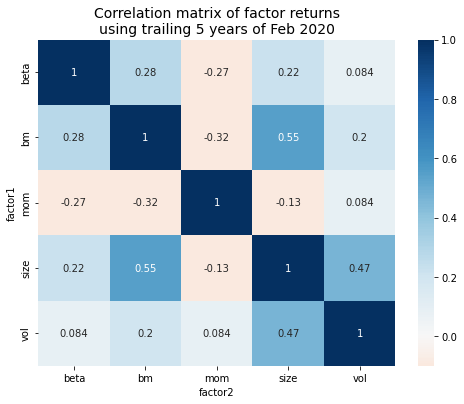

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cov_rho.pivot(index='factor1', columns='factor2', values='rho'), 
            vmin=-0.1, vmax=1, center=0, cmap="RdBu", annot=True, ax=ax);
ax.set_title('Correlation matrix of factor returns\nusing trailing 5 years of Feb 2020', fontsize=14)

In [15]:
# Summary statistics of specific vol
vol.specific_vol.describe()

count    1271.000000
mean        0.096206
std         0.035763
min         0.040259
25%         0.071454
50%         0.089154
75%         0.113519
max         0.286777
Name: specific_vol, dtype: float64

### (c)

### i.

#### A.

In [16]:
# Date
eom_date_factors = datetime(2018, 12, 31)
date_str = eom_date_factors.strftime('%Y-%m-%d')

query = f"select * from crsp_monthly_returns_factors_sc where date = '{date_str}'"
ret_factors = sql.select_query(query)

In [17]:
bool_lowvol = ret_factors.lowvol >= 0.4
bool_small = ret_factors.small <= 0.3

bool_beta = ret_factors.beta >= 0.9
df_folio = ret_factors.loc[bool_lowvol & bool_small & bool_beta]

In [18]:
factors = ['beta', 'bm', 'small', 'mom', 'lowvol']
df_folio[['permno', 'ticker'] + factors].reset_index(drop=True)

,permno,ticker,beta,bm,small,mom,lowvol
0,47896,JPM,1.166451,1.005229,-1.010555,-0.056744,0.435625
1,92655,UNH,0.958786,-0.416877,-0.823640,0.915430,0.488403
2,92611,V,1.024696,-0.780189,-0.803229,0.750197,0.420344
3,38703,WFC,1.072716,1.347780,-0.762199,-0.770459,0.522033
4,76076,CSCO,1.096573,-0.392657,-0.696009,0.893918,0.405997
5,66181,HD,1.177574,-1.101979,-0.693682,-0.498798,0.719116
6,26403,DIS,0.995852,-0.095087,-0.587076,0.033562,0.670811
7,10104,ORCL,0.945417,-0.413417,-0.582557,-0.129398,0.408522
8,20482,ABT,1.194863,-0.302694,-0.432645,1.020348,0.532287
9,22592,MMM,1.062833,-0.835551,-0.349245,-0.847476,0.850621


In [19]:
n = df_folio.shape[0]
df_folio['portfolio_weight'] = 1/n
df_folio[['permno', 'ticker', 'portfolio_weight']].to_csv('data/hw3_portfolio_weights.csv', index=False)

#### B.

In [250]:
print("Portofolio loadings")
h = df_folio[['permno', 'portfolio_weight']].set_index('permno')
X = df_folio[['permno'] + factors].set_index('permno')
(h.transpose() @ X).reset_index(drop=True)

Portofolio loadings


,beta,bm,small,mom,lowvol
0,1.06443,-0.292713,-0.293566,-0.00799,0.635638


The portfolio has a beta close to 1 and an exposure to low vol of around 0.6. There is also negative exposure to book to market and size of around -0.3. There is no exposure to momentum. The intention seems to be to enhance typical market returns by having exposure to low volatility. An investor holding this portfolio likely thinks that the stock market and low vol factor return will be positive for her investment horizon, while at the same time probably believes that book to market an size will have a weak factor return; or at least that the net between low vol and those factor returns will be beneficial for the position.

#### C.

In [251]:
# Adjust date for risk retrieval to avoid data leakage
def get_date_risk(date_factors):
    query = f"select distinct date from reg_coefs"
    eom_dates = sql.select_query(query).sort_values(by='date').reset_index(drop=True).date
    eom_dates_factors_ind = eom_dates[eom_dates == date_factors].index[0]
    eom_date_risk = eom_dates.loc[eom_dates_factors_ind - 1]
    return eom_date_risk

In [252]:
def compute_assets_covariance(date_factors, ref_index=None):

    # Date
    date_risk = get_date_risk(date_factors) # previous month
    date_factors_str = date_factors.strftime('%Y-%m-%d')
    date_risk_str = date_risk.strftime('%Y-%m-%d')

    # Factor exposure
    factors = ['beta', 'bm', 'small', 'mom', 'lowvol']
    query = f"select * from crsp_monthly_returns_factors_sc where date = '{date_factors_str}'"
    ret_factors = sql.select_query(query)
    X = ret_factors.set_index('permno')[factors]
    if ref_index is not None:
        X = X.reindex(ref_index)

    # Factor covariance
    map_factors = {'beta': 'beta', 'bm': 'bm', 'size': 'small', 'mom': 'mom', 'vol': 'lowvol'}
    query = f"select * from reg_cov_rho where date = '{date_risk_str}'"
    cov_rho = sql.select_query(query)
    F = cov_rho.pivot(index='factor1', columns='factor2', values='cov')
    F.rename(columns=map_factors, index=map_factors, inplace=True)
    F = F.reindex(X.columns)[X.columns]

    # Specific vol
    query = f"select * from reg_specific_vol where date = '{date_risk_str}'"
    vol = sql.select_query(query).set_index('permno')
    vol = vol.reindex(X.index)
    vol = vol.dropna()
    X = X.reindex(vol.index)

    # Asset covariance
    Delta = pd.DataFrame(np.diag(vol.specific_vol), index=vol.index, columns=vol.index)
    X.columns = F.columns
    V = X @ F @ X.transpose() + Delta
    
    # Actual returns
    actual_ret = ret_factors.set_index('permno').reindex(X.index)[['logret_1m']]
    
    return V, X, actual_ret

In [253]:
def forecasted_volatility(date_factors, h, verbose=0):
    
    # Assets covariance
    V, _, _ = compute_assets_covariance(date_factors, ref_index=h.index)

    # Risk forecasts
    forecasted_var = (h.transpose() @ V @ h).iloc[0, 0]
    forecasted_vol = np.sqrt(forecasted_var)
    
    return forecasted_vol

In [254]:
forecasted_vol = forecasted_volatility(eom_date_factors, h)
forecasted_vol

0.05781089624270992

#### D.

In [255]:
query = f"""
select permno, ticker, date, ret from crsp_returns
where date between '20190101' and '20201231'
and permno in ({','.join([str(permno) for permno in df_folio.permno])})
"""
daily_ret = sql.select_query(query)

In [256]:
daily_ret.to_csv('data/hw3_daily_returns_of_portfolio_stocks.csv', index=False)

In [257]:
def actual_volatility(date_factors, h):
    bool_year = daily_ret.date.dt.year == (date_factors + relativedelta(months=1)).year
    bool_month = daily_ret.date.dt.month == (date_factors + relativedelta(months=1)).month
    daily_piv = daily_ret.loc[bool_year & bool_month].pivot(index='date', columns='permno', values='ret')[h.index]
    days = daily_piv.shape[0]
    actual_portfolio_returns = daily_piv @ h
    actual_vol = np.sqrt(np.var(actual_portfolio_returns) * days).iloc[0]
    return actual_vol

In [259]:
actual_volatility(eom_date_factors, h)

0.04856673042909824

The forecast was over-estimating volatility of the portfolio (ex-post).

#### ii.

In [260]:
query = f"select distinct date from reg_coefs"
eom_dates = sql.select_query(query).sort_values(by='date').reset_index(drop=True).date

In [261]:
dates = eom_dates[eom_dates >= datetime(2019, 1, 1)]
forecast_vols = []
actual_vols = []
for date in dates:
    forecast_vols.append(forecasted_volatility(date, h))
    actual_vols.append(actual_volatility(date, h))

In [262]:
vol_df = pd.DataFrame({'date': pd.to_datetime(dates), 'forecast': forecast_vols, 'actual': actual_vols}).set_index('date')

Text(0, 0.5, 'Vol (%)')

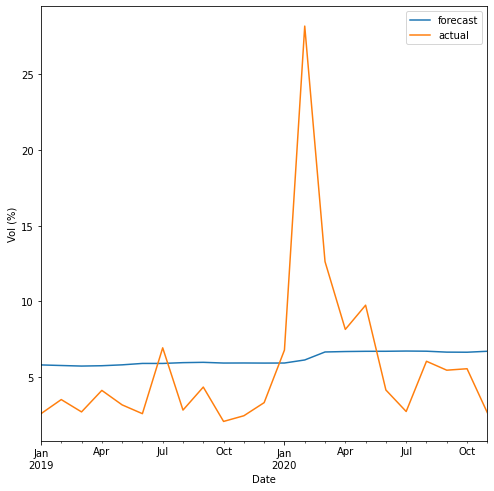

In [263]:
fig, ax = plt.subplots(figsize=(8, 8))
(vol_df*100).plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Vol (%)')

#### iii.

In [264]:
np.sqrt((vol_df**2).sum()/vol_df.shape[0]*12)

forecast    0.215177
actual      0.274657
dtype: float64

In the end, the forecast ended up under-estimating the volatility over the period. Since COVID-19 caused a spike in vol, the small miss is somewhat justified. Over a longer time period the forecast could be more accurate, after all there has not been a crisis every two years.

## Question 2

### (a)

### i.

In [265]:
date_factors = datetime(2019, 12, 31)

In [266]:
V, X, actual_ret = compute_assets_covariance(date_factors)

In [267]:
def compute_expected_returns(X, date_factors, years=10):

    # Factor returns
    reg_coefs = sql.select_query('select * from reg_coefs')
    date_min = date_factors - relativedelta(years=years)
    bool_date_range = (reg_coefs.date < date_factors) & (reg_coefs.date >= date_min)
    factor_ret = reg_coefs.loc[bool_date_range, ['date', 'factor', 'coef']]
    coef_map = {coef: coef for coef in factor_ret.factor.unique()}
    coef_map['size'] = 'small'
    coef_map['vol'] = 'lowvol'
    factor_ret['factor'] = factor_ret.factor.map(coef_map)

    # Expected return
    expected_factor_ret = factor_ret.groupby('factor').mean()
    expected_ret = (X @ expected_factor_ret).rename(columns={'coef': 'ret'})
    
    return expected_ret, expected_factor_ret

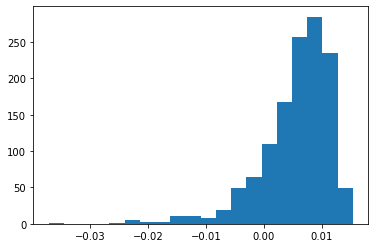

In [268]:
expected_ret, expected_factor_ret = compute_expected_returns(X, date_factors, years=10)
plt.hist(expected_ret, bins=20);

In [275]:
def compute_optimal_weights(expected_ret: pd.Series, V: pd.DataFrame, lmbda=3) -> pd.Series:

    # Parameters
    ret = np.array(expected_ret)
    cov = np.array(V)
    n = len(ret)
    
    # Variables
    ones = np.ones((n, 1))
    w = cp.Variable(n)

    # Optimization
    prob = cp.Problem(
        cp.Minimize(-ret.T @ w
                    + lmbda * cp.quad_form(w, cov)),
        [w >= 0,
         ones.T @ w == 1])
    prob.solve()

    # Weights
    h = w.value
    h[h < 0] = 0
    h = h/h.sum()
    h = pd.Series(h, expected_ret.index)
    
    return h

In [276]:
h = compute_optimal_weights(expected_ret, V, lmbda=3)

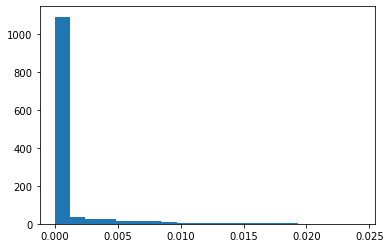

In [277]:
plt.hist(h, bins=20);

In [156]:
expected_port_ret = (h.transpose() @ X @ expected_factor_ret).iloc[0]
expected_port_ret

0.011073529492856463

In [157]:
actual_port_ret = (h.transpose() @ actual_ret).iloc[0]
actual_port_ret

0.02090787583955033

In [248]:
expected_port_var = h.transpose() @ V @ h
expected_port_var

0.0015241401336248922

In [391]:
trading_costs_bp = 10
dates = eom_dates[eom_dates >= datetime(2015, 1, 1)]
expected_port_rets = []
expected_port_vars = []
actual_port_rets_no_tc = []
actual_port_rets_tc = []
h_prev = None

for date in dates:
    print(date, end="\r")
    V, X, actual_ret = compute_assets_covariance(date)
    expected_ret, expected_factor_ret = compute_expected_returns(X, date)
    h = compute_optimal_weights(expected_ret, V)
    
    # Transaction costs
    if h_prev is not None:
        df_h0 = pd.DataFrame(h_prev, columns=['h0'])
        df_h1 = pd.DataFrame(h, columns=['h1'])
        df_h = df_h0.join(df_h1, how='outer').fillna(0)
        df_h['diff'] = (df_h['h1'] - df_h['h0']).abs()
        # NICO: this should be corrected to take into account the returns of the position from t-1 to t!
        transaction_costs_multiplier = 1 - df_h['diff'].sum()*trading_costs_bp/100/100
    else:
        transaction_costs_multiplier = 1
    
    expected_port_ret = (h.transpose() @ X @ expected_factor_ret).iloc[0]
    expected_port_var = h.transpose() @ V @ h
    actual_port_ret_no_tc = (h.transpose() @ actual_ret).iloc[0]
    actual_port_ret_tc = transaction_costs_multiplier*(1 + actual_port_ret_no_tc) - 1
    expected_port_rets.append(expected_port_ret)
    expected_port_vars.append(expected_port_var)
    actual_port_rets_no_tc.append(actual_port_ret_no_tc)
    actual_port_rets_tc.append(actual_port_ret_tc)

    h_prev = h

In [392]:
ret_df = pd.DataFrame({'date': pd.to_datetime(dates), 
                       'expected return': expected_port_rets, 
                       'expected variance': expected_port_vars,
                       'actual return no tc': actual_port_rets_no_tc,
                       'actual return tc': actual_port_rets_tc}
                     ).set_index('date')

# Market returns (log)
reg_coefs = sql.select_query('select * from reg_coefs')
bool_beta_dates = reg_coefs.date.isin(dates) & (reg_coefs.factor=='beta')
mkt_ret = (
    reg_coefs
    .loc[bool_beta_dates, ['date', 'coef']]
    .set_index('date')
    .rename(columns={'coef': 'mkt return'}))

ret_df = ret_df.join(mkt_ret)
ret_df.head()

,expected return,expected variance,actual return no tc,actual return tc,mkt return
date,,,,,
2015-01-30,0.009555,0.001238,0.027811,0.027811,0.056167
2015-02-27,0.009668,0.001182,-0.006772,-0.006937,-0.018582
2015-03-31,0.009817,0.001206,-0.027467,-0.027645,0.004432
2015-04-30,0.009735,0.001213,0.012860,0.012714,0.012088
2015-05-29,0.009634,0.001202,-0.009952,-0.010088,-0.018826


### ii.

I'm using log returns here so I can compute the mean directly. We note annualized expected returns and annualized actual returns are quite close.

In [393]:
# Average returns
name_map = {'expected return': 'expected',
            'actual return no tc': 'actual no tc', 
            'actual return tc': 'actual tc', 
            'mkt return': 'mkt'}
ret_avg = ret_df[['expected return', 'actual return no tc', 'actual return tc', 'mkt return']].mean()*12
ret_avg.index = ret_avg.index.map(name_map)

# Volatility
ret_std = ret_df[['actual return no tc', 'actual return tc', 'mkt return']].std()*np.sqrt(12)
ret_std.index = ret_std.index.map(name_map)
ret_std.loc['expected'] = np.sqrt(ret_df['expected variance'].mean()*12)
ret_std = ret_std.reindex(ret_avg.index)

# Sharpe ratio
sharpe = ret_avg/ret_std

# Collect results
ret_summary = pd.concat((ret_avg, ret_std, sharpe), axis=1)
ret_summary.columns = ['Returns', 'Volatility', 'Sharpe ratio']
ret_summary

,Returns,Volatility,Sharpe ratio
expected,0.124930,0.120300,1.038488
actual no tc,0.099497,0.134096,0.741987
actual tc,0.097236,0.134052,0.725361
mkt,0.096337,0.154231,0.624624


In [394]:
ret_summary.loc[['expected', 'actual no tc']]

,Returns,Volatility,Sharpe ratio
expected,0.124930,0.120300,1.038488
actual no tc,0.099497,0.134096,0.741987


On average the model expected portfolio returns to be 12.5% annualy and reality was 9.9%. Expected return was overly optimistic. Volatility was also overly optimistic. A possible explanation is that any stock-level error in forecasted returns and/or forecasted variance that make the stock more atractive may be picked up by the optimizer which will likely concentrate the portfolio weights to that stock, making the overall result overly optimistic. The forecasted Sharpe ratio was extremely optimistic, as seen by the Sharpe ratio of 1 when the actual Sharpe ratio was 0.74.

### iii

''

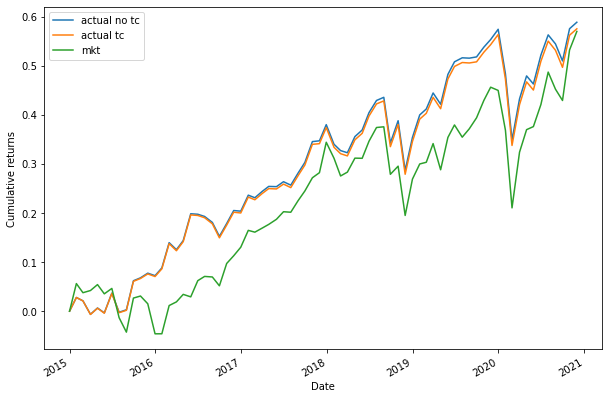

In [395]:
fig, ax = plt.subplots(figsize=(10, 7))
df_plot = (ret_df[['actual return no tc', 'actual return tc', 'mkt return']]
           .rename(columns=name_map)
           .cumsum())
df_plot.loc[datetime(2015, 1, 1)] = 0
df_plot = df_plot.sort_index()
df_plot.plot(ax=ax)
ax.set_ylabel('Cumulative returns')
ax.set_xlabel('Date')
;

In [397]:
ret_summary.loc[['actual no tc', 'actual tc', 'mkt']]

,Returns,Volatility,Sharpe ratio
actual no tc,0.099497,0.134096,0.741987
actual tc,0.097236,0.134052,0.725361
mkt,0.096337,0.154231,0.624624


Actual return of the portfolio is better than the market (9.9% without tc, 9.7% with tc, and 9.6% for the market), standard deviation is lower (around 13.4% regardless of tc, and 15.4% for the market) and Sharpe ratio is higher (0.74 without tc, 0.72 with tc and 0.62 for the market).

Based on results, this strategy seems to be a reasonable alternative since returns were similar and volatility was lower, giving a higher Sharpe ratio than the market. It does seem though that portfolio turnover is high, since the optimizations weights are not linked in anyway from one period to the next. To have a more implementable portfolio it would be good to first improve portfolio turnover.

### (b)

It does have a financial interpretation. The extra term is representing transaction costs based on the change of the portfolio weights. The value of $\nu$ would represent the percentage charged for transaction costs (the cost of transaction costs in USD would be $\nu$ times traded amount in USD). There is a slight improvement that can be done since we are not considering the returns of the position between $t-1$ and $t$. A more precise term for the objective function would use the weights $h_{t-1}$ multiplied by the 1 plus the returns of the position (and then normalized) instead of $h_{t-1}$ directly.

Benefits:
- Sparse solution given use of L1 norm, which makes the number of stocks hold at any moment significantly lower.
- There is now an explicit link between portfolio weights of consecutive periods.
- Transaction costs of a change in position are now taken into account. This is turn should make the resulting strategy have lower turnover and thus lower transactions costs, as compared with the original strategy or one that uses the L1 norm of $h_t$ without substracting $h_{t-1}$.

### (c)

There are at least two ways I can think of for addressing this issue:

1. Adding industry-based factors to the factor model. A possibility would be to add one column per industry, where one meaning the stock belongs to the industry (and no other) and 0 meaning it does not belong to the industry. We could even allow for flexibility here for companies that participate in different industries by making the sum of the weights for all considered industries equal to 1. One draw down of this approach is that now the weighted expected value of these new factor exposures would not be 0, and thus the market return would be distorted. We could address that by mapping the previous [0, 1] range for the column to the range [-1, 1], and then standaridizing the factor exposures as done with the rest. This approach would have the benefit of adding new dimensions to the risk of a certain industry, and thus the benefits of diversification across industries would be better measured by the factor model.
2. Changing the optimization model to be industry concious. One posibility would be to simply include hard industry constraints (e.g. no more than 10% in banking). Another more flexible approach would be to penalize for industry concentration in the objective function.